In [15]:
# @title Importing necessary libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

from sklearn.ensemble import IsolationForest

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [19]:
# @title Reading csv file
df = pd.read_csv('https://raw.githubusercontent.com/jaygodara45/Heartrate-Anomaly-Detection/main/heartrate.csv')
df.head()

datetime  heartrate
0  01/01/22 0:00       94.0
1  01/01/22 0:01       98.0
2  01/01/22 0:02       98.0
3  01/01/22 0:03       95.0
4  01/01/22 0:04       96.0

In [23]:
# @title datetime parsing
datetime_format = '%d/%m/%y %H:%M'
df['datetime'] = pd.to_datetime(df['datetime'], format=datetime_format)
df.head()

datetime  heartrate
0 2022-01-01 00:00:00       94.0
1 2022-01-01 00:01:00       98.0
2 2022-01-01 00:02:00       98.0
3 2022-01-01 00:03:00       95.0
4 2022-01-01 00:04:00       96.0

Handling NaN values using Forward fill

In [24]:
nan_count = df['heartrate'].isna().sum()
print("Number of NaN values in 'heartrate' column:", nan_count)

Number of NaN values in 'heartrate' column: 2025


In [26]:
df['heartrate'].fillna(method='ffill', inplace=True)

**Exploratory data analysis**

In [27]:
# @title Heartrate vs Datetime
fig = px.line(df.reset_index(), x ='datetime', y='heartrate', title='Datetime vs Heartrate')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [30]:
# @title Creating hour and weekday column
df['hour'] = df.datetime.dt.hour
df['weekday'] = pd.Categorical(df.datetime.dt.strftime('%A'), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df.head()

datetime  heartrate  hour   weekday
0 2022-01-01 00:00:00       94.0     0  Saturday
1 2022-01-01 00:01:00       98.0     0  Saturday
2 2022-01-01 00:02:00       98.0     0  Saturday
3 2022-01-01 00:03:00       95.0     0  Saturday
4 2022-01-01 00:04:00       96.0     0  Saturday

<Axes: xlabel='hour'>

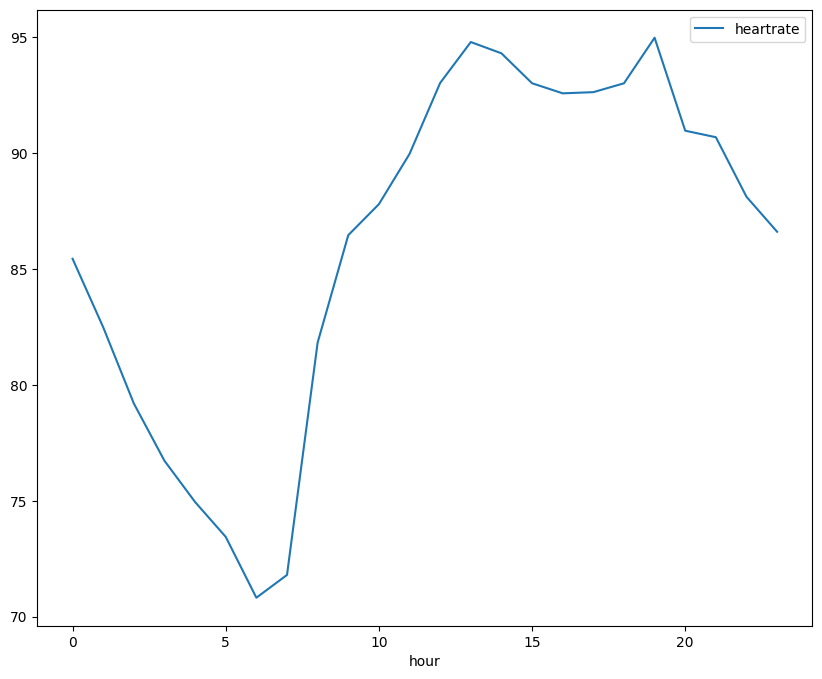

In [31]:
# @title Plotting mean heartrate every hour of the day
df[['heartrate', 'hour']].groupby('hour').mean().plot()

<Axes: xlabel='weekday'>

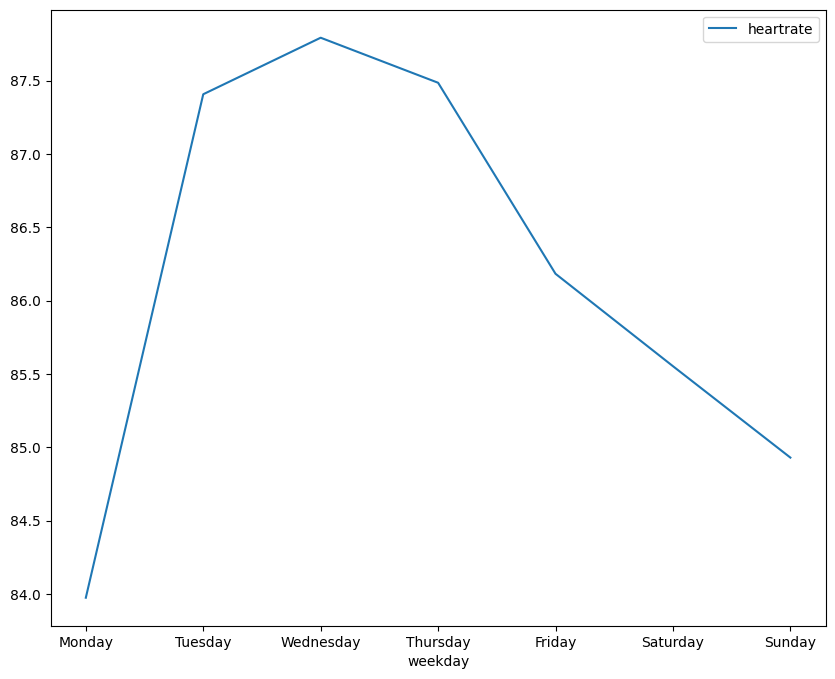

In [32]:
# @title Plotting mean heartrate every weekday of the week
df[['heartrate', 'weekday']].groupby('weekday').mean().plot()

<Axes: xlabel='hour'>

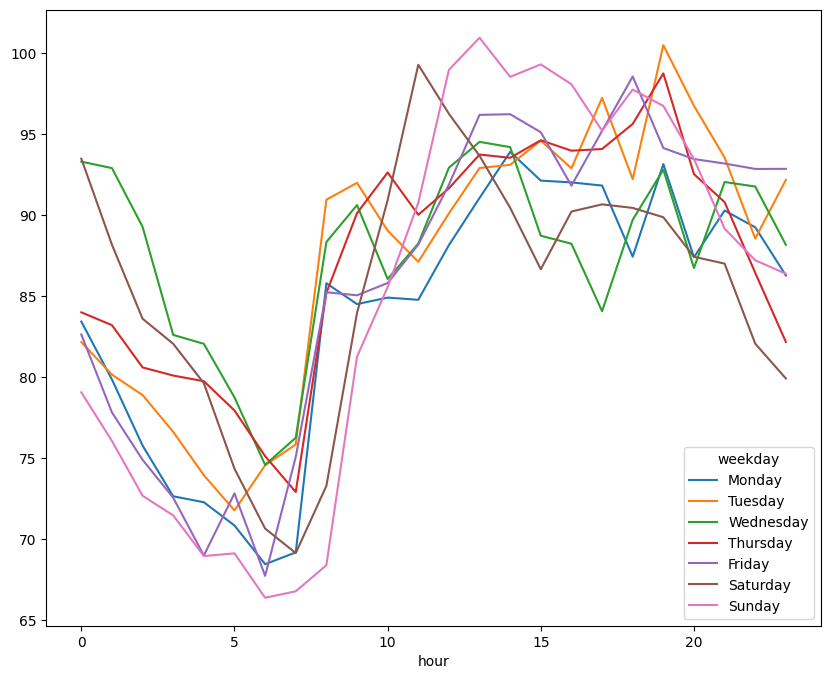

In [34]:
# @title Heartrate hourly on every weekday
df.groupby(['hour', 'weekday']).mean()['heartrate'].unstack().plot()

In [37]:
df_final = df.join(df.groupby(['hour', 'weekday'])['heartrate'].mean(), on=['hour', 'weekday'], rsuffix='_avg')
df_final.head()

datetime  heartrate  hour   weekday  heartrate_avg
0 2022-01-01 00:00:00       94.0     0  Saturday      93.493333
1 2022-01-01 00:01:00       98.0     0  Saturday      93.493333
2 2022-01-01 00:02:00       98.0     0  Saturday      93.493333
3 2022-01-01 00:03:00       95.0     0  Saturday      93.493333
4 2022-01-01 00:04:00       96.0     0  Saturday      93.493333

In [38]:
df_final['day'] = df.datetime.dt.weekday
df_final.head()

datetime  heartrate  hour   weekday  heartrate_avg  day
0 2022-01-01 00:00:00       94.0     0  Saturday      93.493333    5
1 2022-01-01 00:01:00       98.0     0  Saturday      93.493333    5
2 2022-01-01 00:02:00       98.0     0  Saturday      93.493333    5
3 2022-01-01 00:03:00       95.0     0  Saturday      93.493333    5
4 2022-01-01 00:04:00       96.0     0  Saturday      93.493333    5

In [41]:
data = df_final[['heartrate', 'hour', 'day']]
data.head()

heartrate  hour  day
0       94.0     0    5
1       98.0     0    5
2       98.0     0    5
3       95.0     0    5
4       96.0     0    5

In [45]:
model = IsolationForest(contamination=0.002, max_features=3, max_samples=0.8, n_estimators=200)
model.fit(data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



IsolationForest(contamination=0.002, max_features=3, max_samples=0.8,
                n_estimators=200)

In [46]:
df_final['outliers'] = pd.Series(model.predict(data)).apply(lambda x: 'yes' if (x==-1) else 'no')

In [47]:
# @title Plotting heartrate data along with detected anomalies
# @title Heartrate vs Datetime
fig = px.scatter(df_final, x ='datetime', y='heartrate', color='outliers', hover_data=['weekday', 'hour', 'heartrate_avg'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

**Detecting anomalies using score**

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 5.000e+00, 8.000e+00, 7.000e+00,
        2.100e+01, 1.500e+01, 2.400e+01, 1.700e+01, 3.600e+01, 2.600e+01,
        4.900e+01, 4.500e+01, 7.700e+01, 7.700e+01, 1.200e+02, 1.460e+02,
        1.650e+02, 2.810e+02, 3.750e+02, 4.290e+02, 6.590e+02, 6.500e+02,
        1.064e+03, 1.453e+03, 1.945e+03, 2.418e+03, 3.431e+03, 3.919e+03,
        4.403e+03, 5.709e+03, 6.505e+03, 5.056e+03, 3.459e+03, 1.376e+03,
        2.920e+02, 3.590e+02]),
 array([-0.16274526, -0.15490658, -0.1470679 , -0.13922921, -0.13139053,
        -0.12355184, -0.11571316, -0.10787447, -0.10003579, -0.0921971 ,
        -0.08435842, -0.07651973, -0.06868105, -0.06084237, -0.05300368,
        -0.045165  , -0.03732631, -0.02948763, -0.02164894, -0.01381026,
        -0.00597157,  0.00186711,  0.0097058 ,  0.01754448,  0.02538316,
         0.

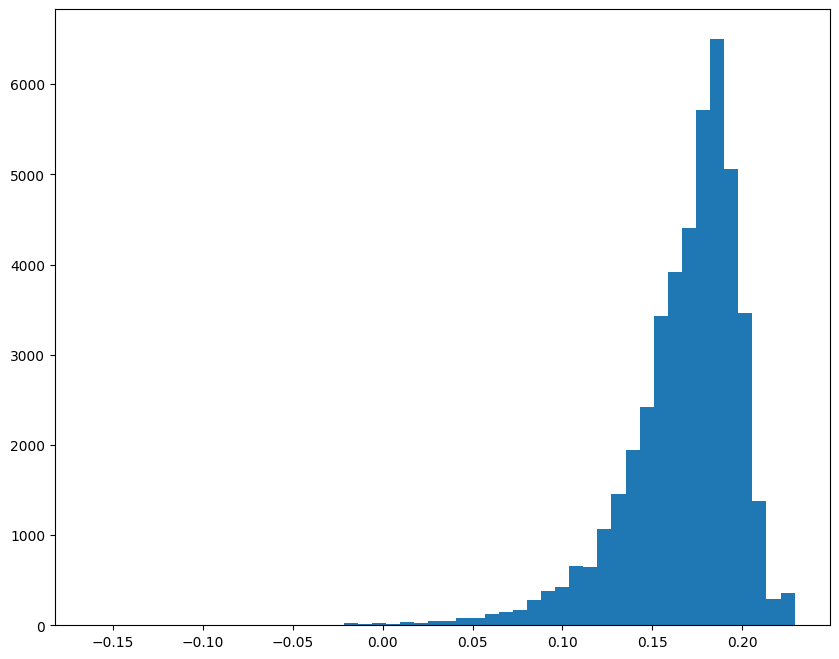

In [48]:
score = model.decision_function(data)
plt.hist(score, bins=50)

In [49]:
# @title Adding scores column in dataframe
df_final['scores'] = score

In [63]:
df_final['outliers_score'] = df_final['scores'].apply(lambda x: 'yes' if x < 0 else 'no')
df_final.head()

datetime  heartrate  hour   weekday  heartrate_avg  day outliers  \
0 2022-01-01 00:00:00       94.0     0  Saturday      93.493333    5       no   
1 2022-01-01 00:01:00       98.0     0  Saturday      93.493333    5       no   
2 2022-01-01 00:02:00       98.0     0  Saturday      93.493333    5       no   
3 2022-01-01 00:03:00       95.0     0  Saturday      93.493333    5       no   
4 2022-01-01 00:04:00       96.0     0  Saturday      93.493333    5       no   

     scores outliers_score  
0  0.138685             no  
1  0.154006             no  
2  0.154006             no  
3  0.131273             no  
4  0.133255             no

In [64]:
# @title Plotting heartrate data along with detected anomalies using score
# @title Heartrate vs Datetime
fig = px.scatter(df_final, x ='datetime', y='heartrate', color='outliers_score', hover_data=['weekday', 'hour', 'heartrate_avg'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()